## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

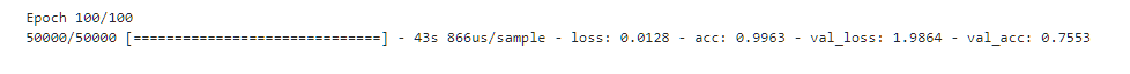

In [6]:
import matplotlib.pyplot as plt
import cv2
img = cv2.imread("Capture.PNG",1)

plt.figure(figsize = (20,2))
plt.axis('off')
plt.imshow(img)

In [2]:
import keras
from keras.datasets import cifar10
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.resnet50 import ResNet50
#from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import os
from math import ceil

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# Fisrt Test by ResNet

In [2]:
batch_size = 64 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 100 # 訓練的 epochs 數量

IMAGE_SIZE = (32, 32)

# 凍結網路層數
FREEZE_LAYERS = 0


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [4]:

# 透過 data augmentation 產生訓練與驗證用的影像資料
# train_datagen = ImageDataGenerator(rotation_range=40,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.2,
#                                    zoom_range=0.2,
#                                    channel_shift_range=10,
#                                    horizontal_flip=True,
#                                    fill_mode='nearest')

# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(num_classes, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(),#lr=1e-3),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())

/opt/conda/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0

In [5]:
# 訓練模型
# net_final.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
#                         steps_per_epoch=ceil(len(x_train) / batch_size), 
#                         epochs=epochs,
#                         validation_data=train_datagen.flow(x_test, y_test, batch_size=batch_size),
#                         validation_steps=ceil(len(x_test) / batch_size),
#                         verbose=1)

history = net_final.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 53s 1ms/sample - loss: 1.9226 - acc: 0.4362 - val_loss: 23.7543 - val_acc: 0.1572
Epoch 2/100
50000/50000 [==============================] - 43s 864us/sample - loss: 1.9796 - acc: 0.4126 - val_loss: 2.2505 - val_acc: 0.3234
Epoch 3/100
50000/50000 [==============================] - 43s 864us/sample - loss: 1.6523 - acc: 0.4702 - val_loss: 1.3205 - val_acc: 0.5212
Epoch 4/100
50000/50000 [==============================] - 43s 864us/sample - loss: 1.4191 - acc: 0.5419 - val_loss: 1.6610 - val_acc: 0.5280
Epoch 5/100
50000/50000 [==============================] - 43s 863us/sample - loss: 1.1124 - acc: 0.6230 - val_loss: 1.0515 - val_acc: 0.6289
Epoch 6/100
50000/50000 [==============================] - 43s 864us/sample - loss: 0.8972 - acc: 0.6949 - val_loss: 1.2015 - val_acc: 0.6094
Epoch 7/100
50000/50000 [==============================] - 43s 864us/sample - loss: 0.8026 - acc: 0

# Another model

In [2]:
from keras.datasets import cifar10
from resnet_builder import resnet # 這是從 resnet_builder.py 中直接 import 撰寫好的 resnet 函數
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import os
from math import ceil

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# 讀取資料集並作前處理
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.
x_test = x_test / 255.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [4]:
# 建立 ResNet 模型

resnet_N = 8
model = resnet(input_shape=(32,32,3), depth=9*resnet_N+2) 
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [5]:
# 透過 data augmentation 產生訓練與驗證用的影像資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [7]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

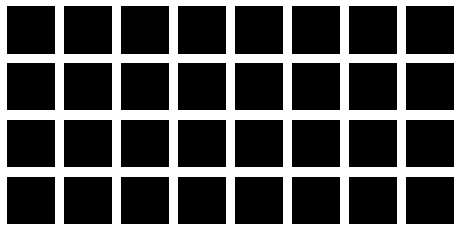

In [10]:
augmented_iamges = next(train_datagen.flow(x_train, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

In [6]:
batch_size = 64 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 100 # 訓練整個資料集共 30個循環

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# history = model.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1,
#                     validation_data=(x_test, y_test))

history = model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
                              steps_per_epoch=ceil(len(x_train) / batch_size), 
                              epochs=epochs,
                              validation_data=train_datagen.flow(x_test, y_test, batch_size=batch_size, shuffle=True),
                              validation_steps=ceil(len(x_test) / batch_size),
                              verbose=1)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/100
782/782 [==============================] - 88s 113ms/step - loss: 3.0586 - accuracy: 0.1328 - val_loss: 2.6072 - val_accuracy: 0.1352
Epoch 2/100
782/782 [==============================] - 71s 91ms/step - loss: 2.4821 - accuracy: 0.1349 - val_loss: 2.3491 - val_accuracy: 0.1466
Epoch 3/100
782/782 [==============================] - 72s 92ms/step - loss: 2.3726 - accuracy: 0.1389 - val_loss: 2.6909 - val_accuracy: 0.1196
Epoch 4/100
 31/782 [>.............................] - ETA: 1:05 - loss: 2.3521 - accuracy: 0.1386

KeyboardInterrupt: 